In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabet/diabetes.csv


In [3]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

In [4]:
import warnings
warnings.simplefilter(action = "ignore") 

# PROJECT 4: Diabetes Prediction

In [5]:
df = pd.read_csv("../input/diabet/diabetes.csv")

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.shape

(768, 9)

In [8]:
df["Outcome"].value_counts()*100/len(df)

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

In [9]:
df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
Pregnancies,768.0,3.845052,3.369578,0.000,0.000,1.00000,3.0000,6.00000,9.0000,10.00000,13.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,85.000,99.00000,117.0000,140.25000,167.0000,181.00000,196.00000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,54.000,62.00000,72.0000,80.00000,88.0000,90.00000,106.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.000,0.00000,23.0000,32.00000,40.0000,44.00000,51.33000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.000,0.00000,30.5000,127.25000,210.0000,293.00000,519.90000,846.00
BMI,768.0,31.992578,7.884160,0.000,23.600,27.30000,32.0000,36.60000,41.5000,44.39500,50.75900,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.165,0.24375,0.3725,0.62625,0.8786,1.13285,1.69833,2.42
Age,768.0,33.240885,11.760232,21.000,22.000,24.00000,29.0000,41.00000,51.0000,58.00000,67.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.000,0.00000,0.0000,1.00000,1.0000,1.00000,1.00000,1.00


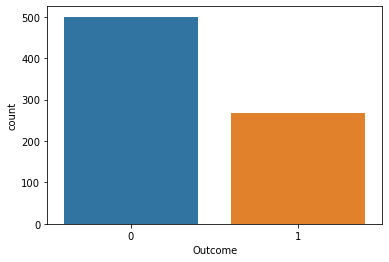

In [10]:
sns.countplot(x = 'Outcome', data = df);

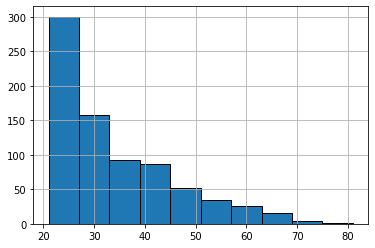

In [11]:
df["Age"].hist(edgecolor = "black");

In [12]:
df.groupby("Outcome").agg({"Pregnancies":"mean"})

,Pregnancies
Outcome,
0,3.298000
1,4.865672


In [13]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


# Data Preprocessing

In [14]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [15]:
for feature in df:
    
    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies no
Glucose no
BloodPressure no
SkinThickness no
Insulin yes
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


In [16]:
Q1 = df["Insulin"].quantile(0.05)
Q3 = df["Insulin"].quantile(0.95)
IQR = Q3-Q1
upper = Q3 + 1.5*IQR

In [17]:
upper

732.5

In [18]:
df[df["Insulin"] > upper]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
13,1,189,60,23,846,30.1,0.398,59,1
228,4,197,70,39,744,36.7,2.329,31,0


In [19]:
df.loc[df["Insulin"] > upper, "Insulin"] = upper

# Lojistik Regresyon (Logistic Regression)

In [20]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis = 1)

In [21]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0.0,33.6,0.627,50
1,1,85,66,29,0.0,26.6,0.351,31
2,8,183,64,0,0.0,23.3,0.672,32
3,1,89,66,23,94.0,28.1,0.167,21
4,0,137,40,35,168.0,43.1,2.288,33


In [22]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [23]:
log_model = LogisticRegression().fit(X,y)

In [24]:
log_model.intercept_

array([-8.72682867])

In [25]:
log_model.coef_

array([[ 0.12969241,  0.03548576, -0.01186781, -0.00447309, -0.00122999,
         0.10029957,  1.036912  ,  0.0113688 ]])

In [26]:
log_model.predict(X)[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [27]:
log_model.predict_proba(X)

array([[0.29300619, 0.70699381],
       [0.95728224, 0.04271776],
       [0.19113494, 0.80886506],
       ...,
       [0.83980198, 0.16019802],
       [0.71560519, 0.28439481],
       [0.93271459, 0.06728541]])

In [28]:
y_pred = log_model.predict(X)

In [29]:
accuracy_score(y, y_pred)

0.7838541666666666

In [30]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.59      0.66       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



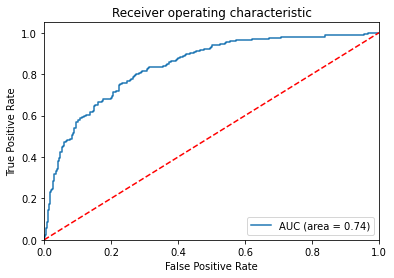

In [31]:
logit_roc_auc = roc_auc_score(y, log_model.predict(X))
fpr, tpr, thresholds = roc_curve(y, log_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [32]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis = 1)

In [33]:
log_model = LogisticRegression().fit(X,y)

In [34]:
y_pred = log_model.predict(X)

In [35]:
accuracy_score(y, y_pred)

0.7838541666666666

In [36]:
cross_val_score(log_model, X, y, cv = 10).mean()

0.7708133971291866

# RF

In [37]:
rf_model = RandomForestClassifier(random_state = 12345).fit(X,y)

In [38]:
cross_val_score(rf_model, X, y, cv = 10).mean()

0.7643028024606972

In [39]:
rf_model

RandomForestClassifier(random_state=12345)

In [40]:
rf_params = {"n_estimators" :[100,200,500,1000], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
            "max_depth": [3,5,8,None]}

In [41]:
rf_model = RandomForestClassifier(random_state = 12345)

In [ ]:
gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = 10,
                    n_jobs = -1,
                    verbose = 2).fit(X, y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.8min


In [ ]:
gs_cv.best_params_

In [ ]:
rf_tuned = RandomForestClassifier(**gs_cv.best_params_)

In [ ]:
cross_val_score(rf_tuned, X, y, cv = 10).mean()

# LightGBM¶

In [ ]:
lgbm = LGBMClassifier(random_state = 12345)

In [ ]:
cross_val_score(lgbm, X, y, cv = 10).mean()

In [ ]:
#model tuning

lgbm_params = {"learning_rate": [0.01, 0.03, 0.05, 0.1, 0.5],
              "n_estimators": [500, 1000, 1500],
              "max_depth":[3,5,8]}

In [ ]:
gs_cv = GridSearchCV(lgbm, 
                     lgbm_params, 
                     cv = 5, 
                     n_jobs = -1, 
                     verbose = 2).fit(X, y)

In [ ]:
lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X,y)

In [ ]:
cross_val_score(lgbm_tuned, X, y, cv = 10).mean()

In [ ]:
feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Değişken Önem Skorları')
plt.ylabel('Değişkenler')
plt.title("Değişken Önem Düzeyleri")
plt.show()

In [ ]:
mean yi-yi^2
|yi-yi|
(yi-yi^2)

cost

In [ ]:
models

In [ ]:
models.append(('LR', LogisticRegression()))

In [ ]:
# Train validation scores of all models

models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', GradientBoostingClassifier()))
models.append(("LightGBM", LGBMClassifier()))

# evaluate each model in turn
results = []
names = []

In [ ]:
for name, model in models:
    
        kfold = KFold(n_splits = 10, random_state = 123456)
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Second method 

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', GradientBoostingClassifier()))
models.append(("LightGBM", LGBMClassifier()))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 46)



# evaluate each model in turn
results = []
names = []
for name, model in models:
    
        kfold = KFold(n_splits = 10, random_state = 123456)
        cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        msg = "%s: (%f)" % (name, acc)
        print(msg)